In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_curve, auc, confusion_matrix



In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
89469,00022208_002.png,Infiltration,2,22208,49,M,PA,3056,2484,0.139,0.139,NaN,../input/data/images_010/images/00022208_002.png,1.0
104400,00027921_000.png,Fibrosis|Infiltration,0,27921,24,M,PA,2522,2565,0.143,0.143,NaN,../input/data/images_011/images/00027921_000.png,1.0
72272,00017800_000.png,No Finding,0,17800,32,F,PA,2718,2991,0.143,0.143,NaN,../input/data/images_008/images/00017800_000.png,0.0


In [3]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

In [4]:
# model = models.inception_v3(pretrained=True)
# model.fc = nn.Sequential(nn.Linear(2048, 1),
#                         nn.Sigmoid())
# model.aux_logits = False
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                        nn.Linear(num_ftrs, 256),  
                        nn.ReLU(), 
                        nn.Dropout(0.2),
                        nn.Linear(256, 1),                   
                        nn.Sigmoid())

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [5]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [ ]:
# model file, disease pairs, plot color
to_test = []
to_test.append(("Hernia", "/kaggle/input/inception-no-hernia-no-infiltration-models/inception_no_hernia.model", "red"))
to_test.append(("Consolidation", "/kaggle/input/inception-no-consolidation-model/inception_no_consolidation.model", "blue"))
to_test.append(("Infiltration", "/kaggle/input/inception-no-hernia-no-infiltration-models/inception_no_infiltration.model", "green"))


In [ ]:
def test(held_out_disease, model_file, color):
    model.load_state_dict(torch.load(model_file))
    model.eval()
    print(f"Running testing for {held_out_disease} with model {model_file}")
    
    held_out_df = all_xray_df[all_xray_df['Finding Labels'] == held_out_disease]
    if held_out_df.shape[0] < 2500:
        held_out_df = held_out_df.sample(held_out_df.shape[0], random_state=25)
    else:
        held_out_df = held_out_df.sample(2500, random_state=25)
    print(f"Num samples with only {held_out_disease}:", held_out_df.shape[0])
    
    no_findings_df = all_xray_df[all_xray_df['Finding Labels'] == "No Finding"]
    no_findings_df = no_findings_df.sample(held_out_df.shape[0], random_state=25)
    print(f"Num samples with No Finding:", no_findings_df.shape[0])
    #no_findings_df = no_findings_df.sample(n=held_out_df.shape[0]) # this might include samples the given model was trainged on, but whatever
    print(f"Keeping {no_findings_df.shape[0]} random 'No Findings' samples for testing")
    
    test_df = held_out_df.append(no_findings_df)
    print(f"Combined test df is {test_df.shape[0]} samples")

    images = list(test_df['path'])
    labels = list(test_df['Binary Labels'].map(lambda x: [x]))

    test = my_set(images, labels, transform = my_transform)
    test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers = 2)
    
    test_correct = 0
    test_total = 0
    pred_label = []
    pred_for_roc_curve = []
    for data, target in tqdm(test_loader):
        target = target.squeeze(1)
        data, target = data.to(device), target.to(device)
        out = model(data)
        predicted = (out>0.5).float()
        pred_label.extend(predicted.tolist())
        pred_for_roc_curve.extend(out.tolist())
        test_correct += (predicted == target).sum().item()
        test_total += target.size(0)
        del data
        gc.collect()
        torch.cuda.empty_cache()
    print('Testing Accuracy: {}'.format((100 * test_correct / test_total)))
    acu = (100 * test_correct / test_total)
    
    model_confusion_matrix = confusion_matrix(labels, pred_label)
    print("Confusion matrix\n", model_confusion_matrix)
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(labels, pred_for_roc_curve)
    c_ax.plot(fpr, tpr, color=color, label='%s AUC:%0.2f'  % (held_out_disease, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.savefig(f"{held_out_disease}.png")
    print("Test done")
    print()

In [ ]:
test(*to_test[0])

In [ ]:
test(*to_test[1])

In [ ]:
test(*to_test[2])

## Covid as the held out

In [6]:
from glob import glob

covid = glob("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/*")
normal = glob("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/*")

mixed = [*([(pat, 1.0) for pat in covid]) , *([(pat, 0.0) for pat in normal])]
import random

random.shuffle(mixed)
images, labels = zip(*mixed)

In [7]:
def test_covid(model_file, color):
    model.load_state_dict(torch.load(model_file))
    model.eval()
    held_out_disease = "covid"
    print(f"Running testing for {held_out_disease} with model {model_file}")
    from glob import glob

    covid = glob("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/*")
    normal = glob("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/*")

    mixed = [*([(pat, 1.0) for pat in covid]) , *([(pat, 0.0) for pat in normal])]
    import random

    random.shuffle(mixed)
    images, labels = zip(*mixed)

    test = my_set(images, labels, transform = my_transform)
    test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers = 2)
    
    test_correct = 0
    test_total = 0
    pred_label = []
    pred_for_roc_curve = []
    for data, target in tqdm(test_loader):
        target = target.squeeze(1)
        data, target = data.to(device), target.to(device)
        out = model(data)
        predicted = (out>0.5).float().flatten()
        pred_label.extend(predicted.tolist())
        pred_for_roc_curve.extend(out.tolist())
        test_correct += (predicted == target).sum().item()
        test_total += target.size(0)
        del data
        gc.collect()
        torch.cuda.empty_cache()
    print('Testing Accuracy: {}'.format((100 * test_correct / test_total)))
    acu = (100 * test_correct / test_total)
    
    model_confusion_matrix = confusion_matrix(labels, pred_label)
    print("Confusion matrix\n", model_confusion_matrix)
    fpr, tpr, thresholds = roc_curve(labels, pred_for_roc_curve)
    return fpr, tpr
#     fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
#     fpr, tpr, thresholds = roc_curve(labels, pred_for_roc_curve)
#     c_ax.plot(fpr, tpr, color=color, label='%s AUC:%0.2f'  % (held_out_disease, auc(fpr, tpr)))
#     c_ax.legend()
#     c_ax.set_xlabel('False Positive Rate')
#     c_ax.set_ylabel('True Positive Rate')
#     plt.savefig(f"{held_out_disease}.png")
#     print("Test done")
#     print()

In [ ]:
hernia = test_covid("/kaggle/input/inception-no-hernia-no-infiltration-models/inception_no_hernia.model", "red")

In [ ]:
no_consolidation = test_covid("/kaggle/input/inception-no-consolidation-model/inception_no_consolidation.model", "purple")

In [ ]:
no_infiltration = test_covid("/kaggle/input/inception-no-hernia-no-infiltration-models/inception_no_infiltration.model", "green")

In [ ]:
leave_nothing_out = test_covid("/kaggle/input/leaving-nothing-out-covid-model/leave_nothing_out.model", "green")

In [ ]:
hernia_fpr, hernia_tpr = hernia
hernia_fpr, hernia_tpr

In [ ]:
no_consolidation_fpr, no_consolidation_tpr = no_consolidation
no_consolidation_fpr, no_consolidation_tpr

In [ ]:
no_infiltration_fpr, no_infiltration_tpr = no_infiltration
no_infiltration_fpr, no_infiltration_tpr

In [ ]:
leave_nothing_out_fpr, leave_nothing_out_tpr = leave_nothing_out
leave_nothing_out_fpr, leave_nothing_out_tpr

In [ ]:
plt.plot(hernia_fpr, hernia_tpr, color="red", label='%s AUC:%0.2f'  % ("hernia", auc(hernia_fpr, hernia_tpr)))
plt.plot(no_consolidation_fpr, no_consolidation_tpr, color="blue", label='%s AUC:%0.2f'  % ("consolidation", auc(no_consolidation_fpr, no_consolidation_tpr)))
plt.plot(no_infiltration_fpr, no_infiltration_tpr, color="green", label='%s AUC:%0.2f'  % ("infiltration", auc(no_infiltration_fpr, no_infiltration_tpr)))
plt.plot(leave_nothing_out_fpr, leave_nothing_out_tpr, color="gold", label='%s AUC:%0.2f'  % ("All Diseases", auc(leave_nothing_out_fpr, leave_nothing_out_tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("Comparing different hold-out disease")
plt.savefig(f"covid_dataset.png")

In [9]:
# densenet testing starts here
hernia_densenet_fpr, hernia_densenet_tpr = test_covid("/kaggle/input/densenet-held-out/densenet_no_hernia.model", "red")


Running testing for covid with model /kaggle/input/densenet-held-out/densenet_no_hernia.model


100%|██████████| 863/863 [04:25<00:00,  3.25it/s]

Testing Accuracy: 82.90121668597914
Confusion matrix
 [[8976 1216]
 [1145 2471]]


In [10]:
consolidation_densenet_fpr, consolidation_densenet_tpr  = test_covid("/kaggle/input/densenet-held-out/densenet_no_consolidation.model", "purple")

Running testing for covid with model /kaggle/input/densenet-held-out/densenet_no_consolidation.model


100%|██████████| 863/863 [04:16<00:00,  3.36it/s]

Testing Accuracy: 85.84878331402086
Confusion matrix
 [[9819  373]
 [1581 2035]]


In [11]:
infiltration_densenet_fpr, infiltration_densenet_tpr = test_covid("/kaggle/input/densenet-held-out/densenet_no_infiltration.model", "green")

Running testing for covid with model /kaggle/input/densenet-held-out/densenet_no_infiltration.model


100%|██████████| 863/863 [04:15<00:00,  3.38it/s]

Testing Accuracy: 77.7013325608343
Confusion matrix
 [[9310  882]
 [2197 1419]]


In [16]:
leave_nothing_out_densenet_fpr, leave_nothing_out_densenet_tpr = test_covid("/kaggle/input/densenet-full/densenet_full.model", "blue")

Running testing for covid with model /kaggle/input/densenet-full/densenet_full.model


100%|██████████| 863/863 [04:15<00:00,  3.38it/s]

Testing Accuracy: 82.14078794901506
Confusion matrix
 [[8855 1337]
 [1129 2487]]


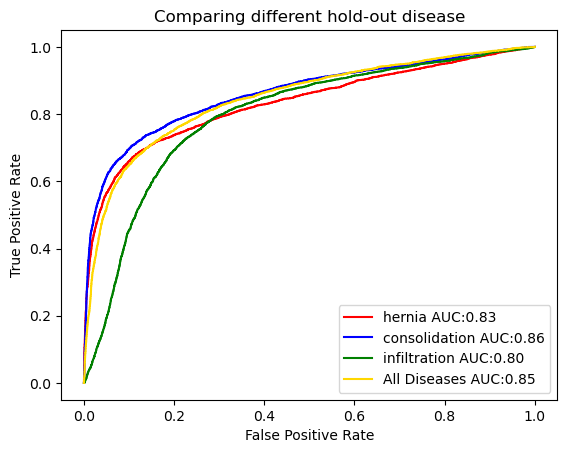

In [18]:
plt.plot(hernia_densenet_fpr, hernia_densenet_tpr, color="red", label='%s AUC:%0.2f'  % ("hernia", auc(hernia_densenet_fpr, hernia_densenet_tpr)))
plt.plot(consolidation_densenet_fpr, consolidation_densenet_tpr, color="blue", label='%s AUC:%0.2f'  % ("consolidation", auc(consolidation_densenet_fpr, consolidation_densenet_tpr)))
plt.plot(infiltration_densenet_fpr, infiltration_densenet_tpr, color="green", label='%s AUC:%0.2f'  % ("infiltration", auc(infiltration_densenet_fpr, infiltration_densenet_tpr)))
plt.plot(leave_nothing_out_densenet_fpr, leave_nothing_out_densenet_tpr, color="gold", label='%s AUC:%0.2f'  % ("All Diseases", auc(leave_nothing_out_densenet_fpr, leave_nothing_out_densenet_tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("Comparing different hold-out disease")
plt.savefig(f"covid_dataset.png")